In [1]:
# Reload all modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import datetime
import io
import pickle
import re
import json
import gzip
import cProfile
import lxml.etree
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
# import ray
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon, box
import geopandas as geopd
import pandas as pd
import querier as qr
from dotenv import load_dotenv
load_dotenv()

import ses_ling.data.socioeconomic as ses_data
import ses_ling.data.access as data_access
import ses_ling.utils.paths as path_utils
import ses_ling.utils.geometry as geo_utils
import ses_ling.utils.spatial_agg as spatial_agg
import ses_ling.utils.text_process as text_process
from ses_ling.language import Region, Language

In [3]:
paths = path_utils.ProjectPaths()
all_cntr_shapes = geopd.read_file(paths.countries_shapefile)

In [4]:
with open(paths.ext_data / 'countries.json') as f:
    countries_dict = json.load(f)
cc = 'GB'
cc_dict = countries_dict[cc]
year_from = 2015
year_to = 2021
assign_kwargs = dict(
    nighttime_acty_th=0.5,
    all_acty_th=0.1,
    count_th=3,
)

In [5]:
_cc_init_params = {cc: {'cell_size': 'MSOA_BGC', 'ses_idx': "IMD"}}
lang = Language(
    'en', 'English', _cc_init_params, all_cntr_shapes, countries_dict,
    year_from=year_from, year_to=year_to,
    latlon_proj=cc_dict['xy_proj'], # TOCHANGE when several countries
    user_nr_words_th=100,
    cells_nr_users_th=15, # this might cause init pb because of setter
    **assign_kwargs
)

# User level

## Quick stats and checks

In [7]:
lang.user_corpora.head()

,nr_tweets,nr_words,nr_unique_words
user_id,,,
00030426231cf2773a81f9897ecbeb951cd2ee7bf2d0118694cf5292edee1720902aed6e5a30783b25d75b7171b376cb81750aef025074226c6d0211a6fb6a9f,64,2507,731
0007831e4682dde226017fbf5d97c58c537a05fd1b55bf0ca4382c3866bdecc18591c37aba8f0b40ccf4899473deb37da34e85ac3cc41e2875fa6660d0fbb955,124,1683,715
000faaaa6e11d566321800c3187781f6651521366dc43312f992b2a145a9e86447232fbb1e3c4f0e76e5ddc3f3f9000715ce6ae3f3c5e2a221c676faa28a85ec,37,445,258
001b4e7bcb4f4980e67d738ef38fe5b63f759e8cdb9938c4ac06354bb37d5f1dfe0e31e522a026e6ba70c2e4a5806b6d4cba9292d472cc6d792c68d9bf72a43c,100,1001,453
001e74edd2ca43f22a6a936eb5315f06bc62a3fcaa1ebd40a06fe05edc6f6687081134f00ba779a51c05e8379cd51c8e802d7bbd53cbaf3b864f9a16a50dc5ae,43,400,233


In [8]:
user_mistakes = lang.user_mistakes
user_mistakes.head()

count  \
user_id                                            cat_id     rule_id                               
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                    2   
                                                   GRAMMAR    DEPEND_ON                         1   
                                                              ORDER_OF_WORDS_WITH_NOT           1   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE      1   
                                                              WHITESPACE_RULE                  37   

                                                                                           default  \
user_id                                            cat_id     rule_id                                
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                   NaN   
                                                   GRAMMAR    DEPEND_ON                        NaN   
                                                              ORDER_OF_WORDS_WITH_NOT          NaN   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE     NaN   
                                                              WHITESPACE_RULE                  NaN   

                                                                                           distance_tokens  \
user_id                                            cat_id     rule_id                                        
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                           NaN   
                                                   GRAMMAR    DEPEND_ON                                NaN   
                                                              ORDER_OF_WORDS_WITH_NOT                  NaN   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE             NaN   
                                                              WHITESPACE_RULE                          NaN   

                                                                                           is_rule_group  \
user_id                                            cat_id     rule_id                                      
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                        True   
                                                   GRAMMAR    DEPEND_ON                             True   
                                                              ORDER_OF_WORDS_WITH_NOT              False   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE           NaN   
                                                              WHITESPACE_RULE                        NaN   

                                                                                           min_prev_matches  \
user_id                                            cat_id     rule_id                                         
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                            NaN   
                                                   GRAMMAR    DEPEND_ON                                 NaN   
                                                              ORDER_OF_WORDS_WITH_NOT                   NaN   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE              NaN   
                                                              WHITESPACE_RULE                           NaN   

                                                                                                                                         name  \
user_id                                            cat_id     rule_id                                                                           
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZAT

In [9]:
lang.user_df.head()

,nr_tweets,nr_words,nr_unique_words,cell_id
user_id,,,,
00030426231cf2773a81f9897ecbeb951cd2ee7bf2d0118694cf5292edee1720902aed6e5a30783b25d75b7171b376cb81750aef025074226c6d0211a6fb6a9f,64,2507,731,E02005567
0007831e4682dde226017fbf5d97c58c537a05fd1b55bf0ca4382c3866bdecc18591c37aba8f0b40ccf4899473deb37da34e85ac3cc41e2875fa6660d0fbb955,124,1683,715,E02001640
000faaaa6e11d566321800c3187781f6651521366dc43312f992b2a145a9e86447232fbb1e3c4f0e76e5ddc3f3f9000715ce6ae3f3c5e2a221c676faa28a85ec,37,445,258,E02005173
001b4e7bcb4f4980e67d738ef38fe5b63f759e8cdb9938c4ac06354bb37d5f1dfe0e31e522a026e6ba70c2e4a5806b6d4cba9292d472cc6d792c68d9bf72a43c,100,1001,453,E02006801
001e74edd2ca43f22a6a936eb5315f06bc62a3fcaa1ebd40a06fe05edc6f6687081134f00ba779a51c05e8379cd51c8e802d7bbd53cbaf3b864f9a16a50dc5ae,43,400,233,E02004279


In [10]:
lang.user_df['nr_words'].describe()

count    3.583340e+05
mean     3.475908e+03
std      1.460625e+04
min      4.000000e+00
25%      3.060000e+02
50%      8.020000e+02
75%      2.201000e+03
max      2.125035e+06
Name: nr_words, dtype: float64

In [ ]:
lang.user_nr_words_th = 100

In [11]:
user_mistakes_cat = lang.user_mistakes.groupby(['user_id', 'cat_id']).sum()

In [12]:
user_mistakes_cat.head()

count  \
user_id                                            cat_id              
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING          2   
                                                   GRAMMAR         2   
                                                   TYPOGRAPHY     38   
                                                   TYPOS           3   
00001a1b91726d1cd5d01471c6166c9fb93fdba2872ca96... CASING         10   

                                                               nr_tweets  \
user_id                                            cat_id                  
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING             86   
                                                   GRAMMAR           172   
                                                   TYPOGRAPHY        172   
                                                   TYPOS              86   
00001a1b91726d1cd5d01471c6166c9fb93fdba2872ca96... CASING            178   

                                                               nr_words  \
user_id                                            cat_id                 
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING           644   
                                                   GRAMMAR         1288   
                                                   TYPOGRAPHY      1288   
                                                   TYPOS            644   
00001a1b91726d1cd5d01471c6166c9fb93fdba2872ca96... CASING          1902   

                                                               nr_unique_words  \
user_id                                            cat_id                        
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING                  123   
                                                   GRAMMAR                 246   
                                                   TYPOGRAPHY              246   
                                                   TYPOS                   123   
00001a1b91726d1cd5d01471c6166c9fb93fdba2872ca96... CASING                  842   

                                                               freq_per_word  \
user_id                                            cat_id                      
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING           0.003106   
                                                   GRAMMAR          0.003106   
                                                   TYPOGRAPHY       0.059006   
                                                   TYPOS            0.004658   
00001a1b91726d1cd5d01471c6166c9fb93fdba2872ca96... CASING           0.010515   

                                                               freq_per_tweet  
user_id                                            cat_id                      
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING            0.023256  
                                                   GRAMMAR           0.023256  
                                                   TYPOGRAPHY        0.441860  
                                                   TYPOS             0.034884  
00001a1b91726d1cd5d01471c6166c9fb93fdba2872ca96... CASING            0.112360

In [76]:
# Most common mistakes
# full_user_mistakes_cat = user_mistakes_cat.unstack(level=1).stack(dropna=False).fillna(0)
# full_user_mistakes_cat.groupby('cat_id').mean().sort_values(by='cat_freq_per_word', ascending=False)
(user_mistakes_cat.groupby('cat_id').sum() / user_mistakes_cat.index.levels[0].size).sort_values(by='freq_per_word', ascending=False)

,cat_freq_per_word,cat_freq_per_tweet
cat_id,,
TYPOGRAPHY,0.023225,0.306905
CASING,0.007341,0.090328
PUNCTUATION,0.006666,0.088851
TYPOS,0.00384,0.048111
GRAMMAR,0.003474,0.044675
MISC,0.001605,0.021474
STYLE,0.001238,0.015237
CONFUSED_WORDS,0.000618,0.007746
REDUNDANCY,0.000207,0.002938


# Cell level

In [ ]:
lang.cells_geodf['nr_users'].describe()

count    7201.000000
mean       49.761700
std       111.547232
min         2.000000
25%        16.000000
50%        24.000000
75%        63.000000
max      7955.000000
Name: nr_users, dtype: float64

In [114]:
lang.cells_nr_users_th = 15

In [14]:
lang.cells_mistakes

Keeping 334174 users out of 358334


count  uavg_freq_per_word  \
cell_id   cat_id rule_id                                           
E02000001 CASING CAPITALIZATION           38            0.000016   
                 CHRISTMAS                72            0.000033   
                 EN_SPECIFIC_CASE        569            0.000171   
                 FILE_EXTENSIONS_CASE     28            0.000006   
                 HALLOWEEN                 9            0.000006   
...                                      ...                 ...   
W02000423 TYPOS  WERE_VBB                  1            0.000004   
                 WHOS                      1            0.000010   
                 WHOS_NN                   2            0.000014   
                 WIFI                      5            0.000030   
                 YOUR_YOU_2                3            0.000181   

                                       uavg_freq_per_tweet  
cell_id   cat_id rule_id                                    
E02000001 CASING CAPITALIZATION                   0.000216  
                 CHRISTMAS                        0.000460  
                 EN_SPECIFIC_CASE                 0.002354  
                 FILE_EXTENSIONS_CASE             0.000091  
                 HALLOWEEN                        0.000060  
...                                                    ...  
W02000423 TYPOS  WERE_VBB                         0.000036  
                 WHOS                             0.000107  
                 WHOS_NN                          0.000181  
                 WIFI                             0.000323  
                 YOUR_YOU_2                       0.002162  

[2176529 rows x 3 columns]

In [293]:
lang.cells_mistakes.groupby(['cell_id', 'cat_id']).sum()['uavg_freq_per_word'].unstack()

cat_id,CASING,COLLOCATIONS,COMPOUNDING,CONFUSED_WORDS,GRAMMAR,MISC,NONSTANDARD_PHRASES,PUNCTUATION,REDUNDANCY,REPETITIONS_STYLE,SEMANTICS,STYLE,TYPOGRAPHY,TYPOS
cell_id,,,,,,,,,,,,,,
E02000001,0.000465,0.000006,0.000012,0.000029,0.000207,0.000112,2.138935e-06,0.000423,0.000021,6.111762e-07,2.945498e-06,0.000062,0.003596,0.000175
E02000002,0.000802,0.000003,NaN,0.000033,0.000086,0.000306,5.116791e-06,0.000489,NaN,NaN,NaN,0.000026,0.000939,0.000433
E02000003,0.000453,0.000015,0.000006,0.000069,0.000162,0.000147,NaN,0.000439,0.000007,NaN,NaN,0.000110,0.001358,0.000366
E02000004,0.000308,0.000016,0.000103,0.000034,0.000240,0.000094,NaN,0.000559,0.000020,NaN,NaN,0.000178,0.001841,0.000419
E02000005,0.000131,0.000004,0.000004,0.000015,0.000096,0.000030,2.593484e-08,0.000235,0.000016,NaN,3.540931e-07,0.000044,0.000417,0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W02000419,0.000367,0.000002,0.000025,0.000078,0.000217,0.000030,8.169769e-07,0.000331,0.000005,NaN,4.161196e-07,0.000093,0.000646,0.000223
W02000420,0.000385,0.000006,0.000011,0.000028,0.000170,0.000088,1.928625e-07,0.000353,0.000009,1.590277e-07,5.885650e-07,0.000042,0.001058,0.000141
W02000421,0.000337,0.000002,0.000016,0.000024,0.000144,0.000074,1.376747e-07,0.000303,0.000008,NaN,1.252527e-06,0.000034,0.001326,0.000167


### Viz single cat/rule

(<Figure size 283.465x386.429 with 2 Axes>, (<AxesSubplot:>,))

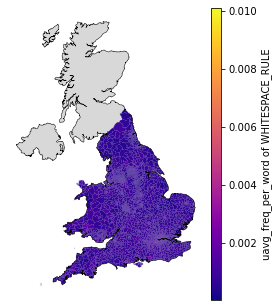

In [330]:
lang.map_mistake('WHITESPACE_RULE', normed_bboxes=False, total_width=100)

(<Figure size 283.465x386.429 with 2 Axes>, (<AxesSubplot:>,))

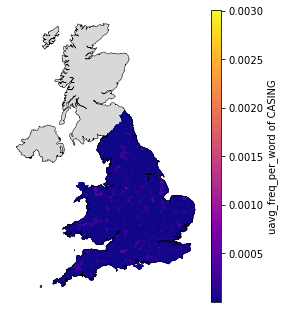

In [332]:
lang.map_cat('CASING', normed_bboxes=False, total_width=100)

In [63]:
lang.cells_mistakes

count  uavg_freq_per_word  \
cell_id   cat_id rule_id                                           
E02000001 CASING AI                        1        7.845845e-06   
                 CAPITALIZATION           38        1.173815e-06   
                 CHRISTMAS                72        2.412628e-06   
                 EN_SPECIFIC_CASE        571        1.487956e-05   
                 FILE_EXTENSIONS_CASE     28        4.534073e-07   
...                                      ...                 ...   
W02000423 TYPOS  WERE_VBB                  1        2.387074e-07   
                 WHOS                      1        6.545861e-07   
                 WHOS_NN                   2        9.190083e-07   
                 WIFI                      5        2.025294e-06   
                 YOUR_YOU_2                3        1.213817e-05   

                                       uavg_freq_per_tweet  
cell_id   cat_id rule_id                                    
E02000001 CASING AI                               0.000055  
                 CAPITALIZATION                   0.000016  
                 CHRISTMAS                        0.000033  
                 EN_SPECIFIC_CASE                 0.000190  
                 FILE_EXTENSIONS_CASE             0.000007  
...                                                    ...  
W02000423 TYPOS  WERE_VBB                         0.000002  
                 WHOS                             0.000007  
                 WHOS_NN                          0.000012  
                 WIFI                             0.000022  
                 YOUR_YOU_2                       0.000145  

[2184130 rows x 3 columns]

In [65]:
lang.cells_mistakes.groupby(['cell_id', 'cat_id'])['uavg_freq_per_word'].sum().unstack().fillna(0)

cat_id,CASING,COLLOCATIONS,COMPOUNDING,CONFUSED_WORDS,GRAMMAR,MISC,NONSTANDARD_PHRASES,PUNCTUATION,REDUNDANCY,REPETITIONS_STYLE,SEMANTICS,STYLE,TYPOGRAPHY,TYPOS
cell_id,,,,,,,,,,,,,,
E02000001,0.000465,0.000006,0.000012,0.000029,0.000207,0.000112,2.138935e-06,0.000423,0.000021,6.111762e-07,2.945498e-06,0.000062,0.003596,0.000175
E02000002,0.000802,0.000003,NaN,0.000033,0.000086,0.000306,5.116791e-06,0.000489,NaN,NaN,NaN,0.000026,0.000939,0.000433
E02000003,0.000453,0.000015,0.000006,0.000069,0.000162,0.000147,NaN,0.000439,0.000007,NaN,NaN,0.000110,0.001358,0.000366
E02000004,0.000308,0.000016,0.000103,0.000034,0.000240,0.000094,NaN,0.000559,0.000020,NaN,NaN,0.000178,0.001841,0.000419
E02000005,0.000131,0.000004,0.000004,0.000015,0.000096,0.000030,2.593484e-08,0.000235,0.000016,NaN,3.540931e-07,0.000044,0.000417,0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W02000419,0.000367,0.000002,0.000025,0.000078,0.000217,0.000030,8.169769e-07,0.000331,0.000005,NaN,4.161196e-07,0.000093,0.000646,0.000223
W02000420,0.000385,0.000006,0.000011,0.000028,0.000170,0.000088,1.928625e-07,0.000353,0.000009,1.590277e-07,5.885650e-07,0.000042,0.001058,0.000141
W02000421,0.000337,0.000002,0.000016,0.000024,0.000144,0.000074,1.376747e-07,0.000303,0.000008,NaN,1.252527e-06,0.000034,0.001326,0.000167


In [66]:
cat_avg_freq = lang.cells_mistakes.groupby(['cell_id', 'cat_id'])['uavg_freq_per_word'].sum().unstack().fillna(0)
m = lang.cells_geodf.join(cat_avg_freq, how='inner').explore('GRAMMAR')

In [71]:
m.save(lang.paths.case_figs / 'mistake_cat_freqs.html')

### SES / inter-rules/cats correlations

correlation betwen rules freqs to recover categories, see if they match LT's

also simple quesrion like: are tweets hsorter in poorer areas? pb: twitter change in 2017 of tweets' max length. should be ok if enough users per cell, but atm it's clearly not enough with the 10-20

investigate influence of neihbouring cells, communities on speech. is a poor area surrounded by rich ones going t be speaking "more standard"? correlation Gi (not star!) with cell's own z-score

count all mistakes, diversity of mistakes, aggregate from clustering 
vector of mistake freq, PCA? into hierarchical, compare with socio economical

rank correlation for when imd is just given in terms of rank?

In [23]:
lang._cells_ses_df = pd.DataFrame()

In [26]:
lang.add_ses_idx('total_income')

In [32]:
wavg_ses = lang.cells_ses_df['wavg'].unstack()
uavg_all_cats_freq = lang.cells_mistakes.groupby(['cell_id'])['uavg_freq_per_word'].sum().fillna(0).loc[lang.cells_mask]
# corrs = wavg_ses.join(uavg_all_cats_freq, how='inner',).corr()

In [33]:
wavg_ses.corrwith(uavg_all_cats_freq,)# method='spearman')

metric
asscore                  -0.035047
bhsscore                  0.114690
criscore                  0.254282
cypscore                  0.018400
eduscore                  0.026583
empscore                  0.128646
envscore                  0.241854
gbscore                  -0.321084
hddscore                  0.076884
idcscore                  0.185545
idoscore                  0.296559
imdscore                  0.185501
incscore                  0.190978
indscore                  0.100844
outscore                  0.348966
total annual income ()    0.084388
totpop                    0.070050
wbscore                   0.366093
dtype: float64

In [34]:
wavg_ses = lang.cells_ses_df['wavg'].unstack()
uavg_cat_freq = lang.cells_mistakes.groupby(['cell_id', 'cat_id'])['uavg_freq_per_word'].sum().unstack().fillna(0).loc[lang.cells_mask]
# uavg_rule_freq = lang.cells_mistakes['uavg_freq_per_word'].unstack().fillna(0).droplevel(-1)
corrs = wavg_ses.join(uavg_cat_freq, how='inner',).corr()

In [38]:
corrs.loc[wavg_ses.columns, uavg_cat_freq.columns]

cat_id,CASING,COLLOCATIONS,COMPOUNDING,CONFUSED_WORDS,GRAMMAR,MISC,NONSTANDARD_PHRASES,PUNCTUATION,REDUNDANCY,REPETITIONS_STYLE,SEMANTICS,STYLE,TYPOGRAPHY,TYPOS
metric,,,,,,,,,,,,,,
asscore,-0.039105,0.056871,0.025922,0.348772,0.430945,0.155719,0.003921,0.177871,-0.048147,-0.020016,-0.053590,0.284069,-0.248110,0.364784
bhsscore,-0.037121,-0.016492,-0.023088,-0.104688,-0.154117,-0.071804,0.025450,-0.023091,0.016432,0.049492,0.041349,0.013603,0.179832,-0.091224
criscore,0.069512,0.025341,0.004362,0.176043,0.256816,0.075722,0.017552,0.114395,-0.050260,-0.013563,-0.004574,0.221099,0.098232,0.253734
cypscore,-0.047537,0.052875,0.029285,0.254689,0.310244,0.110661,0.014843,0.162821,-0.019886,-0.018076,-0.041360,0.210350,-0.138947,0.270174
eduscore,-0.043390,0.053835,0.024102,0.301225,0.378392,0.138840,0.013039,0.171720,-0.039562,-0.025062,-0.043027,0.242072,-0.160730,0.326588
empscore,-0.023897,0.025297,0.024148,0.265811,0.343567,0.163973,0.015165,0.109392,-0.031420,-0.024941,-0.013815,0.176700,-0.033178,0.304391
envscore,-0.011591,0.000327,0.001984,-0.050435,-0.099718,0.001779,0.036516,-0.027051,0.021400,0.019140,0.036134,-0.048756,0.282125,-0.034146
gbscore,-0.135726,0.000488,0.003896,-0.066669,-0.136623,-0.031112,-0.010144,-0.061949,0.022643,0.002928,-0.025130,-0.157003,-0.205540,-0.174480
hddscore,-0.008391,0.024342,0.024696,0.274287,0.348326,0.146846,0.008718,0.121395,-0.036039,-0.035633,-0.020128,0.203718,-0.094485,0.302468


In [59]:
max_corr_by_ses_idx = corrs.loc[wavg_ses.columns, uavg_cat_freq.columns].abs().idxmax(axis=1)
max_corr_by_ses_idx = max_corr_by_ses_idx.rename(uavg_cat_freq.columns.name).to_frame().assign(r=corrs.stack().loc[zip(max_corr_by_ses_idx.index, max_corr_by_ses_idx.values)].values)
max_corr_by_ses_idx

,cat_id,r
metric,,
asscore,GRAMMAR,0.430945
bhsscore,TYPOGRAPHY,0.179832
criscore,GRAMMAR,0.256816
cypscore,GRAMMAR,0.310244
eduscore,GRAMMAR,0.378392
empscore,GRAMMAR,0.343567
envscore,TYPOGRAPHY,0.282125
gbscore,TYPOGRAPHY,-0.205540
hddscore,GRAMMAR,0.348326


In [64]:
max_corr_by_cat = corrs.loc[wavg_ses.columns, uavg_cat_freq.columns].abs().idxmax(axis=0)
max_corr_by_cat = max_corr_by_cat.rename(wavg_ses.columns.name).to_frame().assign(r=corrs.stack().loc[zip(max_corr_by_cat.index, max_corr_by_cat.values)].values)
max_corr_by_cat

,metric,r
cat_id,,
CASING,gbscore,-0.135726
COLLOCATIONS,asscore,0.056871
COMPOUNDING,cypscore,0.029285
CONFUSED_WORDS,asscore,0.348772
GRAMMAR,asscore,0.430945
MISC,empscore,0.163973
NONSTANDARD_PHRASES,envscore,0.036516
PUNCTUATION,asscore,0.177871
REDUNDANCY,criscore,-0.050260


In [50]:
uavg_cat_freq

cat_id,CASING,COLLOCATIONS,COMPOUNDING,CONFUSED_WORDS,GRAMMAR,MISC,NONSTANDARD_PHRASES,PUNCTUATION,REDUNDANCY,REPETITIONS_STYLE,SEMANTICS,STYLE,TYPOGRAPHY,TYPOS
cell_id,,,,,,,,,,,,,,
E02000001,0.000465,0.000006,0.000012,0.000029,0.000207,0.000112,2.138935e-06,0.000423,0.000021,6.111762e-07,2.945498e-06,0.000062,0.003596,0.000175
E02000002,0.000802,0.000003,0.000000,0.000033,0.000086,0.000306,5.116791e-06,0.000489,0.000000,0.000000e+00,0.000000e+00,0.000026,0.000939,0.000433
E02000003,0.000453,0.000015,0.000006,0.000069,0.000162,0.000147,0.000000e+00,0.000439,0.000007,0.000000e+00,0.000000e+00,0.000110,0.001358,0.000366
E02000004,0.000308,0.000016,0.000103,0.000034,0.000240,0.000094,0.000000e+00,0.000559,0.000020,0.000000e+00,0.000000e+00,0.000178,0.001841,0.000419
E02000005,0.000131,0.000004,0.000004,0.000015,0.000096,0.000030,2.593484e-08,0.000235,0.000016,0.000000e+00,3.540931e-07,0.000044,0.000417,0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W02000419,0.000367,0.000002,0.000025,0.000078,0.000217,0.000030,8.169769e-07,0.000331,0.000005,0.000000e+00,4.161196e-07,0.000093,0.000646,0.000223
W02000420,0.000385,0.000006,0.000011,0.000028,0.000170,0.000088,1.928625e-07,0.000353,0.000009,1.590277e-07,5.885650e-07,0.000042,0.001058,0.000141
W02000421,0.000337,0.000002,0.000016,0.000024,0.000144,0.000074,1.376747e-07,0.000303,0.000008,0.000000e+00,1.252527e-06,0.000034,0.001326,0.000167


## Corr viz

TODO: corrplot, pd scatter_matrix

<AxesSubplot:xlabel='GRAMMAR', ylabel='asscore'>

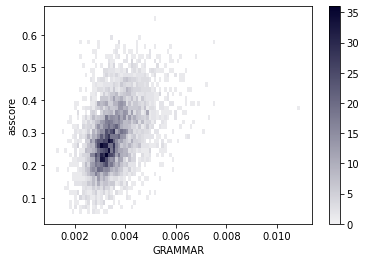

In [68]:
sns.histplot(
    x=uavg_cat_freq.loc[lang.relevant_cells, 'GRAMMAR'],
    y=wavg_ses.loc[lang.relevant_cells, 'asscore'],
    # binrange=((0, 5e-4), None),
    cmap="light:#03012d",
    cbar=True,
)

/home/thomaslouf/.conda/envs/ses-ling/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='TYPOS', ylabel='imdscore'>

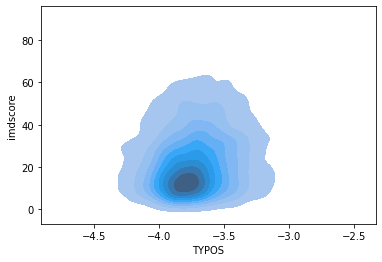

In [58]:
sns.kdeplot(
    x=np.log10(uavg_cat_freq.loc[lang.relevant_cells, 'TYPOS']),
    y=wavg_ses.loc[lang.relevant_cells, 'imdscore'],
    fill=True,
)

next, when actual good correlation, sns.regplot / lmplot

## Mistakes vectors approach

TODO: check

In [460]:
lang.cells_mistakes.head()

count  uavg_freq_per_word  \
cell_id   cat_id rule_id                                           
E02000001 CASING CAPITALIZATION           38        1.192747e-06   
                 CHRISTMAS                72        2.451539e-06   
                 EN_SPECIFIC_CASE        569        1.267142e-05   
                 FILE_EXTENSIONS_CASE     28        4.607199e-07   
                 HALLOWEEN                 9        4.244201e-07   

                                       uavg_freq_per_tweet  
cell_id   cat_id rule_id                                    
E02000001 CASING CAPITALIZATION                   0.000016  
                 CHRISTMAS                        0.000034  
                 EN_SPECIFIC_CASE                 0.000174  
                 FILE_EXTENSIONS_CASE             0.000007  
                 HALLOWEEN                        0.000004

In [273]:
cats_to_keep = ['STYLE', 'GRAMMAR', 'COMPOUNDING', 'CONFUSED_WORDS', 'COLLOCATIONS', 'PLAIN_ENGLISH', 'NONSTANDARD_PHRASES']
lang.cells_mistakes.loc[lang.cells_mistakes.index.isin(cats_to_keep, level=1), :]

count  \
cell_id   cat_id       rule_id                                     
E02000001 COLLOCATIONS ACCOMPANY_WITH                          1   
                       ACCUSE_FOR_OF                           1   
                       ANGRY_AGAINST_WITH                      1   
                       ARRIVE_ON_AT_THE_BEACH                 11   
                       ASK_TO                                  2   
...                                                          ...   
W02000423 STYLE        ENGLISH_WORD_REPEAT_BEGINNING_RULE      1   
                       EXTREME_ADJECTIVES                      6   
                       GONNA                                  18   
                       NOT_SURE_IT_WORKS                       1   
                       WANNA                                   4   

                                                           uavg_freq_per_word  \
cell_id   cat_id       rule_id                                                  
E02000001 COLLOCATIONS ACCOMPANY_WITH                            9.426805e-08   
                       ACCUSE_FOR_OF                             1.139703e-09   
                       ANGRY_AGAINST_WITH                        1.924368e-07   
                       ARRIVE_ON_AT_THE_BEACH                    3.408956e-07   
                       ASK_TO                                    5.677402e-08   
...                                                                       ...   
W02000423 STYLE        ENGLISH_WORD_REPEAT_BEGINNING_RULE        2.538174e-06   
                       EXTREME_ADJECTIVES                        3.726384e-06   
                       GONNA                                     4.366146e-05   
                       NOT_SURE_IT_WORKS                         2.417309e-07   
                       WANNA                                     9.181804e-06   

                                                           uavg_freq_per_tweet  
cell_id   cat_id       rule_id                                                  
E02000001 COLLOCATIONS ACCOMPANY_WITH                             2.657461e-06  
                       ACCUSE_FOR_OF                              1.412470e-08  
                       ANGRY_AGAINST_WITH                         9.458760e-07  
                       ARRIVE_ON_AT_THE_BEACH                     4.026713e-06  
                       ASK_TO                                     9.001664e-07  
...                                                                        ...  
W02000423 STYLE        ENGLISH_WORD_REPEAT_BEGINNING_RULE         3.360893e-05  
                       EXTREME_ADJECTIVES                         4.433262e-05  
                       GONNA                                      4.589989e-04  
                       NOT_SURE_IT_WORKS                          3.563652e-06  
                       WANNA                                      9.595586e-05  

[1386957 rows x 3 columns]

In [274]:
cells_mistakes_mat = lang.cells_mistakes.loc[lang.cells_mistakes.index.isin(cats_to_keep, level=1), 'uavg_freq_per_word'].droplevel('cat_id').unstack().fillna(0).loc[lang.relevant_cells]

In [463]:
cells_mistakes_mat.shape

(5022, 1685)

In [282]:
from sklearn.decomposition import PCA

TODO PCA with ses variables, what drives cinome variation

focus on city? London eg

In [291]:
n_components = 5
decomp = PCA(n_components=n_components).fit(cells_mistakes_mat.to_numpy())

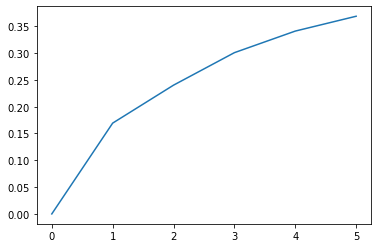

In [292]:
plt.plot(np.arange(n_components+1)[:20], np.insert(decomp.explained_variance_ratio_.cumsum(), 0, 0)[:20])

In [255]:
cells_mistakes_mat.head()

rule_id,A3FT,ABBREVIATION_PUNCTUATION,ABLE_TO_PASSIVE,ABLE_VBP,ABOUT_ITS_NN,ABOUT_TO_VBD,ABOUT_WHO_TO,ABOVE_MENTIONED,ABSORB_AT_IN,ACCEPT_EXCEPT,...,YOU_GOOD,YOU_HAV,YOU_R,YOU_RE_AREN_T,YOU_THING,YOU_TUBE,YO_TO,Y_ALL,ZERO_DAY_EXPLOIT_HYPHEN,Z_WAVE
msoa11cd,,,,,,,,,,,,,,,,,,,,,
E02000001,0.0,7.192379e-07,0.0,3.323830e-08,3.060044e-07,1.701423e-08,1.178848e-08,0.0,0.0,0.0,...,4.734366e-09,2.083816e-09,1.840856e-07,0.0,1.014473e-09,7.762325e-08,4.078502e-07,6.162624e-06,0.0,0.0
E02000003,0.0,2.537363e-06,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.221757e-05,0.000000e+00,0.0,0.0
E02000004,0.0,7.011070e-06,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
E02000008,0.0,9.205235e-06,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.786352e-05,0.0,0.0
E02000009,0.0,4.127273e-06,0.0,0.000000e+00,6.561180e-08,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,3.144714e-06,0.000000e+00,7.423795e-07,0.0,0.000000e+00,0.000000e+00,2.106594e-06,3.936708e-07,0.0,0.0


In [287]:
comps = decomp.components_
loading_order = np.argsort(np.abs(comps[0]))[::-1]
pd.Series(comps[0][loading_order], index=cells_mistakes_mat.columns[loading_order])

rule_id
GONNA              0.829264
WANNA              0.451806
HE_VERB_AGR        0.193973
PRP_VBG            0.100921
THE_SUPERLATIVE    0.091545
                     ...   
TOSS_UP_HYPHEN    -0.000000
FOUD_FOUND        -0.000000
ENSUE_ENSURE      -0.000000
LOCKHEED_MARTIN   -0.000000
COUNSEL_GENERAL   -0.000000
Length: 1685, dtype: float64

In [446]:
comps[0].shape

(1685,)

In [295]:
import scipy.cluster.hierarchy as shc

In [448]:
proj_vectors = decomp.transform(cells_mistakes_mat.to_numpy())

In [451]:
comp_cell_val = pd.Series(proj_vectors[:, 0], index=cells_mistakes_mat.index)

In [452]:
comp_cell_val.head()

msoa11cd
E02000001   -0.000011
E02000003    0.000022
E02000004    0.000076
E02000008    0.000051
E02000009    0.000013
dtype: float64

(<Figure size 504.567x606.614 with 2 Axes>,
 array([<AxesSubplot:>], dtype=object))

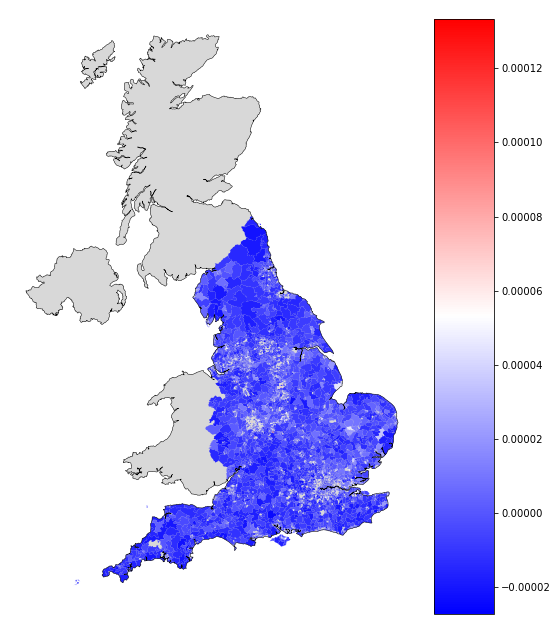

In [454]:
lang.map_continuous_choro(comp_cell_val.rename('comp0_cell_val'), cmap='bwr')

In [303]:
linkage = shc.linkage(vectors, method='ward')
# if max_n_clusters is None:
n_clusters = None
# else:
#     n_clusters = np.asarray(range(2, max_n_clusters + 1))
cut_tree = shc.cut_tree(linkage, n_clusters=np.asarray(range(2, 10 + 1)))

In [443]:
cl_df = pd.DataFrame({'level0': cut_tree[:, 0]}, index=cells_mistakes_mat.index)

In [437]:
m = lang.cells_geodf.join(cl_df, how='inner').explore('level0')

In [441]:
lang.cells_ses_df['wavg'].unstack()['eduscore']

msoa11cd
E02000001     5.456302
E02000002    31.115365
E02000003    17.860425
E02000004    22.919929
E02000005    27.022661
               ...    
E02006930     6.334212
E02006931     6.516718
E02006932    27.442333
E02006933    20.142661
E02006934    17.812394
Name: eduscore, Length: 6791, dtype: float64

In [444]:
cl_df.join(lang.cells_ses_df['wavg'].unstack()['eduscore'], how='inner').groupby('level0').mean()

,eduscore
level0,
0,17.506897
1,22.945604


In [438]:
m.save(lang.paths.case_figs / 'basic_clustering.html')

below: tests

In [328]:
r = lang.regions[0]
r.cell_levels_corr = spatial_agg.levels_corr(
    r.paths.ext_data / cc_dict['cell_levels_corr_files']['census'], r.ses_df, r.cells_geodf.index.name, weight_col='totpop'
)

In [334]:
weight_df = ses_data.read_df(
    r.paths.ext_data, **cc_dict['ses_data_options']['IMD']
)

In [396]:
r.ses_data_options = cc_dict['ses_data_options']
r.ses_idx = 'total_income'

In [397]:
r.ses_df = r.load_ses_df()

In [368]:
r.ses_data_options = cc_dict['ses_data_options']
r.ses_idx = 'total_income'
# ses assumed at smallest cells' level
r.ses_df = r.load_ses_df()

# may not be used but does not cost much to load (just a small csv)
cell_shapefile_kind = r.cell_shapefiles[r.cell_size]["kind"]
corr_path = (
    r.paths.ext_data
    / r.cell_levels_corr_files[cell_shapefile_kind]
)
agg_level = r.cells_geodf.index.name
opt = r.ses_data_options[r.ses_idx]
if 'weight_col' in opt:
    weight_df = r.ses_df
    weight_col = opt['weight_col']
else:
    weight_opt = r.ses_data_options[opt['weight_from']]
    weight_df = ses_data.read_df(
        r.paths.ext_data, **weight_opt
    )
r.cell_levels_corr = spatial_agg.levels_corr(
    corr_path, weight_df, agg_level, weight_col=weight_col
)

In [337]:
cell_shapefile_kind = r.cell_shapefiles[r.cell_size]["kind"]
corr_path = (
    r.paths.ext_data
    / r.cell_levels_corr_files[cell_shapefile_kind]
)
cell_levels_corr = spatial_agg.levels_corr(
    corr_path, weight_df, 'msoa11cd', weight_col='totpop'
)

In [338]:
cell_levels_corr

weight  w_sum  w_normed
msoa11cd  lsoa11cd                          
E02000001 E01000001    1296   6687  0.193809
          E01000002    1156   6687  0.172873
          E01000003    1350   6687  0.201884
          E01000005    1121   6687  0.167639
          E01032739     802   6687  0.119934
...                     ...    ...       ...
E02006933 E01033765    1445   6703  0.215575
E02006934 E01033751    2071   6878  0.301105
          E01033752    2084   6878  0.302995
          E01033753    1230   6878  0.178831
          E01033755    1493   6878  0.217069

[32844 rows x 3 columns]

In [335]:
weight_df

,incscore,criscore,asscore,hddscore,bhsscore,imdscore,idoscore,wbscore,outscore,idcscore,empscore,eduscore,indscore,cypscore,totpop,gbscore,envscore
lsoa11cd,,,,,,,,,,,,,,,,,
E01000816,0.084,0.363,0.301,-1.019,27.108,14.081,0.065,2.004,0.726,0.146,0.064,14.048,-0.139,-0.216,1473,0.106,20.821
E01000818,0.066,0.574,0.282,-1.383,32.846,13.454,0.076,1.208,0.271,0.078,0.057,10.096,-0.042,-0.538,1517,0.697,17.920
E01000819,0.194,0.642,0.330,-0.247,32.701,26.536,0.310,4.254,0.763,0.253,0.120,16.000,0.094,-0.271,1732,-0.619,24.467
E01000820,0.138,0.608,0.214,-0.106,22.748,21.127,0.156,2.672,0.685,0.145,0.127,6.868,-0.104,-0.424,1511,-0.713,20.864
E01000822,0.102,-0.095,0.231,-0.176,20.774,13.278,0.173,2.533,0.629,0.135,0.066,6.928,-0.018,-0.543,1705,-1.096,21.480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E01033764,0.470,1.316,0.613,2.361,16.867,74.468,0.544,0.969,0.750,0.414,0.341,73.723,-0.189,1.135,2712,-0.402,20.426
E01033765,0.362,1.015,0.479,1.665,19.411,59.599,0.455,0.874,0.283,0.492,0.280,59.571,-0.554,1.374,1445,-0.098,12.584
E01033766,0.099,0.054,0.178,0.823,4.477,21.895,0.207,-1.360,0.629,0.097,0.073,11.133,1.513,0.138,1054,-1.459,58.942


In [312]:
lang['wavg'].join(cl_df, how='inner')

wavg          wvar          avg            var  \
msoa11cd  metric                                                            
E02000001 incscore     0.065100      0.000840     0.062667       0.006066   
          criscore    -1.655914      0.034241    -1.660833       0.222821   
          asscore      0.107293      0.001810     0.104167       0.012981   
          hddscore    -0.686336      0.058635    -0.670500       0.377913   
          bhsscore    35.655980      8.455482    36.271333      63.382866   
...                         ...           ...          ...            ...   
E02006934 indscore     1.047584      0.016809     1.004250       0.103691   
          cypscore     0.469125      0.088068     0.412750       0.407442   
          totpop    1799.076185  32861.018374  1719.500000  182441.666667   
          gbscore     -0.193580      0.017028    -0.191500       0.106892   
          envscore    42.242945     39.639772    40.931750     228.634161   

                         min       max  weight  nr_units        wstd  level0  
msoa11cd  metric                                                              
E02000001 incscore     0.007     0.211    6687         6    0.028983       0  
          criscore    -2.343    -1.032    6687         6    0.185044       0  
          asscore      0.032     0.321    6687         6    0.042540       0  
          hddscore    -1.654    -0.102    6687         6    0.242147       0  
          bhsscore    24.412    46.314    6687         6    2.907831       0  
...                      ...       ...     ...       ...         ...     ...  
E02006934 indscore     0.554     1.302    6878         4    0.129650       0  
          cypscore     0.002     1.364    6878         4    0.296762       0  
          totpop    1230.000  2084.000    6878         4  181.276083       0  
          gbscore     -0.628     0.128    6878         4    0.130492       0  
          envscore    23.033    55.481    6878         4    6.296012       0  

[85374 rows x 10 columns]